In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
max_features = 1000000
Vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features, output_mode='tf_idf', ngrams=2)

In [4]:
Vectorizer.adapt(np.array(df['text']))

In [5]:
vocab = Vectorizer.get_vocabulary()

In [6]:
num_tokens = len(vocab)
print(num_tokens)

246970


In [7]:
#model = tf.keras.Sequential([
#    Vectorizer,
#    tf.keras.layers.Dense(32, activation='relu'),
#    tf.keras.layers.Dense(3, activation='softmax')
#])

In [8]:
def create_model(neurons=10, layers=2):
    model = tf.keras.Sequential()
    model.add(Vectorizer)
    
    for n in range(layers):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(1e-3),
             metrics=['accuracy'])
    return model

In [9]:
#model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#             optimizer=tf.keras.optimizers.Adam(1e-3),
#             metrics=['accuracy'])

In [10]:
X = df['text']
y = df['author']

In [11]:
training_labels_bools = []

for author in y:
    if "EAP" == author:
        training_labels_bools.append([1,0,0])
    elif "HPL" == author:
        training_labels_bools.append([0,1,0])
    elif "MWS" == author:
        training_labels_bools.append([0,0,1])

In [12]:
y = training_labels_bools

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [14]:
X_train.values

array(['But this discovery was so great and overwhelming that all the steps by which I had been progressively led to it were obliterated, and I beheld only the result.',
       'I said to myself, "This is no dream, for by what means can I prove the greater reality of that other life in the house of stone and brick south of the sinister swamp and the cemetery on the low hillock, where the Pole Star peers into my north window each night?"',
       'A robin red breast dropt from the frosty branches of the trees, upon the congealed rivulet; its panting breast and half closed eyes shewed that it was dying: a hawk appeared in the air; sudden fear seized the little creature; it exerted its last strength, throwing itself on its back, raising its talons in impotent defence against its powerful enemy.',
       ...,
       'The manner in which Wyatt received this harmless pleasantry convinced me, at once, that he was mad.',
       'She first assured him of her boundless confidence; of this he mus

In [49]:
model = KerasClassifier(build_fn=create_model, batch_size=32, verbose=1)

neurons = [10, 15, 20, 25]
layers = [2, 4, 6]
epochs = [1]

param_grid = dict(neurons=neurons, epochs=epochs, layers=layers)
grid = GridSearchCV(estimator=model, scoring='neg_log_loss', param_grid=param_grid, n_jobs=1, cv=3, verbose=3)

grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


PicklingError: Could not pickle the task to send it to the workers.

In [42]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

-0.522816 (0.033024) with: {'epochs': 1, 'layers': 2, 'neurons': 10}
-0.478060 (0.023191) with: {'epochs': 1, 'layers': 2, 'neurons': 15}
-0.463463 (0.016577) with: {'epochs': 1, 'layers': 2, 'neurons': 20}
-0.452476 (0.002246) with: {'epochs': 1, 'layers': 2, 'neurons': 25}
-0.750873 (0.004904) with: {'epochs': 1, 'layers': 4, 'neurons': 10}
-0.604579 (0.034661) with: {'epochs': 1, 'layers': 4, 'neurons': 15}
-0.553242 (0.054707) with: {'epochs': 1, 'layers': 4, 'neurons': 20}
-0.495336 (0.005248) with: {'epochs': 1, 'layers': 4, 'neurons': 25}
-0.868138 (0.047309) with: {'epochs': 1, 'layers': 6, 'neurons': 10}
-0.716137 (0.078205) with: {'epochs': 1, 'layers': 6, 'neurons': 15}
-0.752999 (0.077932) with: {'epochs': 1, 'layers': 6, 'neurons': 20}
-0.639832 (0.050428) with: {'epochs': 1, 'layers': 6, 'neurons': 25}


In [47]:
scores = pd.DataFrame({
    "mean": means,
    "stdev": stds,
    "params": params
})
scores.sort_values('mean', ascending=False)

,mean,stdev,params
3,-0.452476,0.002246,"{'epochs': 1, 'layers': 2, 'neurons': 25}"
2,-0.463463,0.016577,"{'epochs': 1, 'layers': 2, 'neurons': 20}"
1,-0.478060,0.023191,"{'epochs': 1, 'layers': 2, 'neurons': 15}"
7,-0.495336,0.005248,"{'epochs': 1, 'layers': 4, 'neurons': 25}"
0,-0.522816,0.033024,"{'epochs': 1, 'layers': 2, 'neurons': 10}"
6,-0.553242,0.054707,"{'epochs': 1, 'layers': 4, 'neurons': 20}"
5,-0.604579,0.034661,"{'epochs': 1, 'layers': 4, 'neurons': 15}"
11,-0.639832,0.050428,"{'epochs': 1, 'layers': 6, 'neurons': 25}"
9,-0.716137,0.078205,"{'epochs': 1, 'layers': 6, 'neurons': 15}"
4,-0.750873,0.004904,"{'epochs': 1, 'layers': 4, 'neurons': 10}"


In [24]:
model1 = create_model(neurons=25, layers=1).fit(list(X_train), y_train, epochs=1, batch_size=64,
         validation_data=(list(X_test),y_test),
         validation_steps=10)

230/230 [==============================] - 9s 37ms/step - loss: 0.5567 - accuracy: 0.7723 - val_loss: 0.4079 - val_accuracy: 0.8594


In [17]:
predict = model.predict(list(X_test))

for pred in predict:
    max_index = np.argmax(pred)
    
    for i in range(len(pred)):
        if i == max_index:
            pred[i] = 1
        else:
            pred[i] = 0
print(predict)

AttributeError: 'History' object has no attribute 'predict'

In [16]:
def confusion(predictions, test_labels):
    matrix = np.zeros([3,3], dtype=int)
    
    i = 0
    for row in predictions:
        matrix[np.argmax(row), np.argmax(test_labels[i])] += 1
        i += 1
        
    return matrix

confusion(predict, y_test)
    
                

array([[1700,  199,  198],
       [  93, 1096,   51],
       [ 144,   84, 1330]])

Text(33.0, 0.5, 'True')

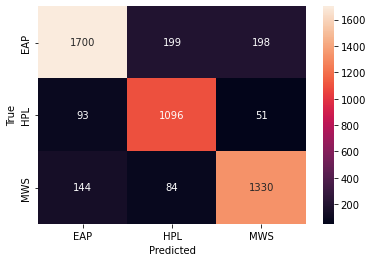

In [17]:
x_axis_labels = ['EAP', 'HPL', 'MWS']
y_axis_labels = ['EAP', 'HPL', 'MWS']

ax = sns.heatmap(confusion(predict, y_test), xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [18]:
print("test accuracy = ", sum(np.argmax(predict, axis=1) == np.argmax(y_test, axis=1))/len(y_test))

test accuracy =  0.8429009193054137


In [19]:
model.predict(["Go Blue"])

array([[0.24186449, 0.4738592 , 0.2842763 ]], dtype=float32)

In [19]:
test_df = pd.read_csv('test_copy.csv')
test_df.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [20]:
test_df['EAP'] = 0
test_df['HPL'] = 0
test_df['MWS'] = 0

In [21]:
test_df.head()

,id,text,EAP,HPL,MWS
0,id02310,"Still, as I urged our leaving Ireland with suc...",0,0,0
1,id24541,"If a fire wanted fanning, it could readily be ...",0,0,0
2,id00134,And when they had broken down the frail door t...,0,0,0
3,id27757,While I was thinking how I should possibly man...,0,0,0
4,id04081,I am not sure to what limit his knowledge may ...,0,0,0


In [22]:
X_sub = test_df['text']

In [26]:
sub_pred = model1.predict(X_sub)
sub_pred

AttributeError: 'History' object has no attribute 'predict'

In [25]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "EAP": sub_pred[:, 0],
    "HPL": sub_pred[:, 1],
    "MWS": sub_pred[:, 2]
})
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.000567,1.904040e-05,9.994138e-01
1,id24541,1.000000,2.102892e-10,4.927420e-09
2,id00134,0.000002,9.999827e-01,1.484115e-05
3,id27757,0.999981,1.609015e-05,3.156577e-06
4,id04081,0.176412,2.596113e-01,5.639762e-01


In [26]:
#submission.to_csv("submission.csv", index=False)